


# ARTDARTA-DALL-E






---




#### What is this?

This is a notepad that uses a decoder to work with the DALL-E neural network and CLIP to create images from text. The best images created are used to create NFT tokens in the [Artificial Intelligence Machine Art](https://opensea.io/collection/aiartmachine) collection in OpenSea. As the project evolves, we will make it simpler, better, and more user-friendly.

Feel free to send correspondence to [@KlimovichArtem](https://twitter.com/KlimovichArtem) on Twitter. If you use this notebook or modify it, please be cool and link back to my twitter. 

The notebook was created with tremendous help from [@advadnoun](https://twitter.com/advadnoun)



---



#### Thanks!

Many thanks to OpenAI for releasing their models CLIP and DALL-E (the encoder and decoder parts, specifically). I am not affiliated with them.


Original https://github.com/openai/DALL-E/ (Aditya Ramesh, Mikhail Pavlov, Gabriel Goh, Scott Gray, Chelsea Voss, Alec Radford, Mark Chen, Ilya Sutskever). Clone https://github.com/artemklimovich/ARTDARTA-DALL-E

Original https://github.com/openai/CLIP (Alec Radford, \* Jong Wook Kim,\* Chris Hallacy, Aditya Ramesh, Gabriel Goh, Sandhini Agarwal,
Girish Sastry, Amanda Askell, Pamela Mishkin, Jack Clark, Gretchen Krueger, Ilya Sutskever). Clone https://github.com/artemklimovich/ARTDARTA-DALL-E/tree/master/CLIP

\* equal contribution

Also, as a good launching point for future directions and to find more related work, see https://distill.pub/2017/feature-visualization/ by Chris Olah, Alexander Mordvintsev, Ludwig Schubert.



---



# How do I use this?

First, type in your description where it says *Insert text here*.


Second, click the 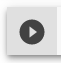 
button that shows up next to the text under the heading **This one!**. The button appears when you move your mouse over the text **This one!** Wait for a bit as it loads and goes in circles, and then move on to the third step when it finishes running.

Third, click on the upper bar at the top of the page where it says **Runtime**, and then click **Restart and run all**. 

Your output will appear at the bottom of this page as it trains after a little while. Scroll down below everything else to see new images appear. The images will start by looking like dirt, but the page will eventually ding and show new images as it begins to attempt to match the image to your description. 

# Choose Text

In [ ]:
text_input = '''god'''

# This one!

In [ ]:
import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = ""
else:
    torch_version_suffix = "+cu110"

!pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html ftfy regex

CUDA version: 11.1
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |███████████████████████         | 834.1 MB 1.4 MB/s eta 0:03:52tcmalloc: large alloc 1147494400 bytes == 0x56284b7be000 @  0x7f681d7f1615 0x5628115704cc 0x56281165047a 0x5628115732ed 0x562811664e1d 0x5628115e6e99 0x5628115e19ee 0x562811574bda 0x5628115e6d00 0x5628115e19ee 0x562811574bda 0x5628115e3737 0x562811665c66 0x5628115e2daf 0x562811665c66 0x5628115e2daf 0x562811665c66 0x5628115e2daf 0x562811575039 0x5628115b8409 0x562811573c52 0x5628115e6c25 0x5628115e19ee 0x562811574bda 0x5628115e3737 0x5628115e19ee 0x562811574bda 0x5628115e2915 0x562811574afa 0x5628115e2c0d 0x5628115e19ee
     |█████████████████████████████▏  | 1055.7 MB 1.4 MB/s eta 0:01:15tcmalloc: large alloc 1434370048 bytes == 0x56288fe14000 @  0x7f681d7f1615 0x5628115704cc 0x56281165047a 0x5628115732ed 0x562811664e1d 0x5628115e6e99 0x5628115e19ee 0x562811574bda 0x5628115e6d00 0x5628115e19ee 0x562811574bda 0x5628115e3737 0x562811

# Top


In [ ]:
# don't use half of these lol

import torch
import numpy as np
import torchvision
import torchvision.transforms.functional as TF

import PIL
import matplotlib.pyplot as plt

import os
import random
import imageio
from IPython import display
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import glob

from google.colab import output



In [ ]:
# were you lucky today?

!nvidia-smi -L


GPU 0: Tesla K80 (UUID: GPU-e5813936-4152-040e-aa99-df4a5c833991)


# Perceptor

In [ ]:


%cd /content/

!git clone https://github.com/artemklimovich/ARTDARTA-CLIP.git


%cd /content/CLIP/

!pip install ftfy

import os
import CLIP
import torch

clip.available_models()

import numpy as np

# Load the model
perceptor, preprocess = clip.load('ViT-B/32', jit=True)
perceptor = perceptor.eval()

/content
fatal: destination path 'ARTDARTA-CLIP' already exists and is not an empty directory.
/content/CLIP


['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

# Params

In [ ]:
# probably don't mess with this unless you're changing generator size
im_shape = [512, 512, 3]
sideX, sideY, channels = im_shape
batch_size = 1

# Define

In [ ]:
def displ(img, pre_scaled=True):
  img = np.array(img)[:,:,:]
  img = np.transpose(img, (1, 2, 0))
  if not pre_scaled:
    img = scale(img, 48*4, 32*4)
  imageio.imwrite(str(3) + '.png', np.array(img))
  return display.Image(str(3)+'.png')

def gallery(array, ncols=2):
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result

def card_padded(im, to_pad=3):
  return np.pad(np.pad(np.pad(im, [[1,1], [1,1], [0,0]],constant_values=0), [[2,2], [2,2], [0,0]],constant_values=1),
            [[to_pad,to_pad], [to_pad,to_pad], [0,0]],constant_values=0)

def get_all(img):
  img = np.transpose(img, (0,2,3,1))
  cards = np.zeros((img.shape[0], sideX+12, sideY+12, 3))
  for i in range(len(img)):
    cards[i] = card_padded(img[i])
  print(img.shape)
  cards = gallery(cards)
  imageio.imwrite(str(3) + '.png', np.array(cards))
  return display.Image(str(3)+'.png')
  

# Generator

In [ ]:
import io
import os, sys
import requests
import PIL

import torch
import torchvision.transforms as T
import torchvision.transforms.functional as TF

!pip install git+https://github.com/artemklimovich/ARTDARTA-DALL-E.git


from dall_e import map_pixels, unmap_pixels, load_model
target_image_size = sideX

def preprocess(img):
    s = min(img.size)
    
    if s < target_image_size:
        raise ValueError(f'min dim for image {s} < {target_image_size}')
        
    r = target_image_size / s
    s = (round(r * img.size[1]), round(r * img.size[0]))
    img = TF.resize(img, s, interpolation=PIL.Image.LANCZOS)
    img = TF.center_crop(img, output_size=2 * [target_image_size])
    img = torch.unsqueeze(T.ToTensor()(img), 0)
    return map_pixels(img)


model = load_model("https://cdn.openai.com/dall-e/decoder.pkl", 'cuda')
encoder = load_model("https://cdn.openai.com/dall-e/encoder.pkl", 'cuda')


  Cloning https://github.com/artemklimovich/ARTDARTA-DALL-E.git to /tmp/pip-req-build-wl61zuaf
  Running command git clone -q https://github.com/artemklimovich/ARTDARTA-DALL-E.git /tmp/pip-req-build-wl61zuaf


In [ ]:
oi = encoder(map_pixels(.2*torch.nn.functional.interpolate(torch.rand(1, 3, sideX//4, sideY//4), (sideX, sideY))).cuda())

# Latent coordinates

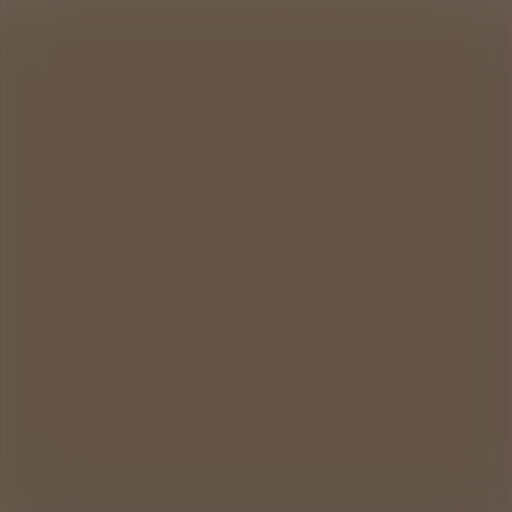

In [ ]:


class Pars(torch.nn.Module):
    def __init__(self):
        super(Pars, self).__init__()


        hots = torch.nn.functional.one_hot((torch.arange(0, 8192).to(torch.int64)), num_classes=8192)
        rng = torch.zeros(batch_size, 64*64, 8192).uniform_()**torch.zeros(batch_size, 64*64, 8192).uniform_(.1,1)
        for b in range(batch_size):
          for i in range(64**2):
            rng[b,i] = hots[[np.random.randint(8191)]]

        rng = rng.permute(0, 2, 1)

        self.normu = torch.nn.Parameter(rng.cuda().view(batch_size, 8192, 64, 64))

        # ended up not doing static, as the brown seems to actually work better here

        # self.normu = torch.nn.Parameter(oi.cuda().clone())



    def forward(self):

      
      normu = torch.softmax(hadies*self.normu.reshape(batch_size, 8192//2, -1), dim=1).view(batch_size, 8192, 64, 64)
      return normu


lats = Pars().cuda()
mapper = [lats.normu]
optimizer = torch.optim.Adam([{'params': mapper, 'lr': .05}])
eps = 0



tx = clip.tokenize(text_input)
t = perceptor.encode_text(tx.cuda()).detach().clone()


nom = torchvision.transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))


will_it = False
hadies = 1.
with torch.no_grad():
  al = unmap_pixels(torch.sigmoid(model(lats()).cpu().float())).numpy()
  for allls in al:
    displ(allls[:3])
    print('\n')
  # print(lats())
  # print(lats().sum())

# Train

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



  ##########################################################
   [0, tensor([-2.4355], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 0


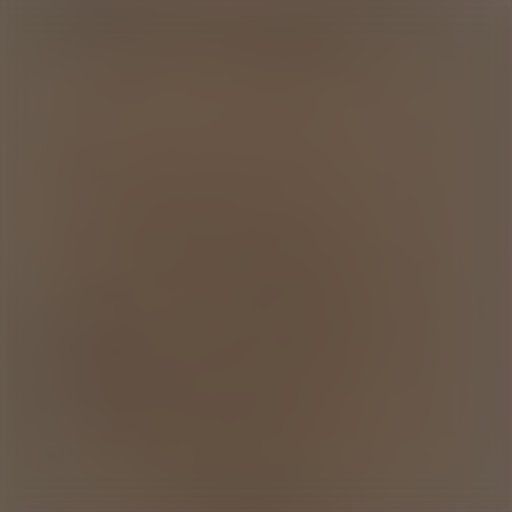




  ##########################################################
   [0, tensor([-2.9102], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 50


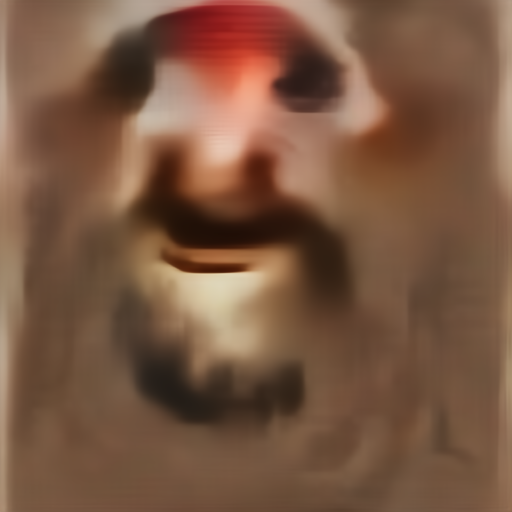




  ##########################################################
   [0, tensor([-3.4688], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 100


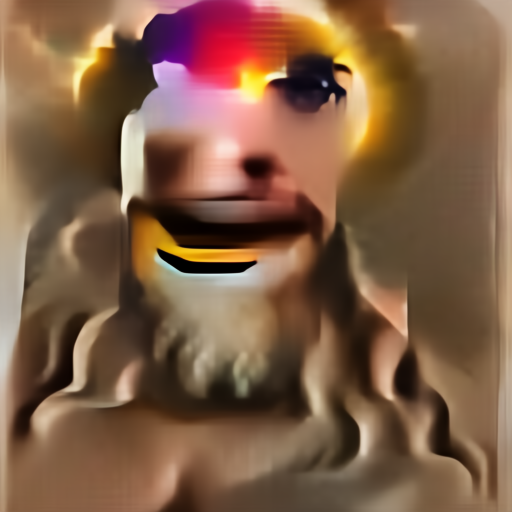




  ##########################################################
   [0, tensor([-3.6426], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 150


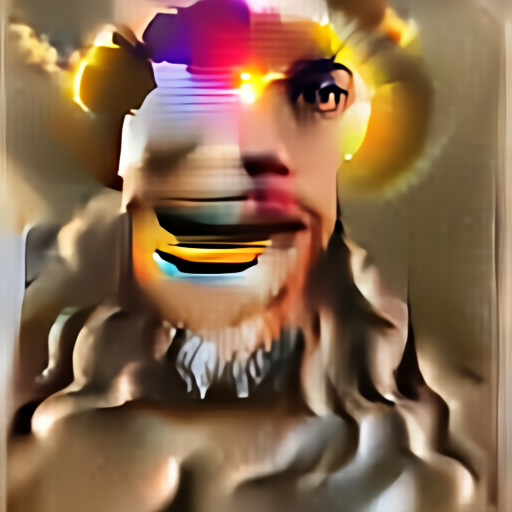




  ##########################################################
   [0, tensor([-3.8457], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 200


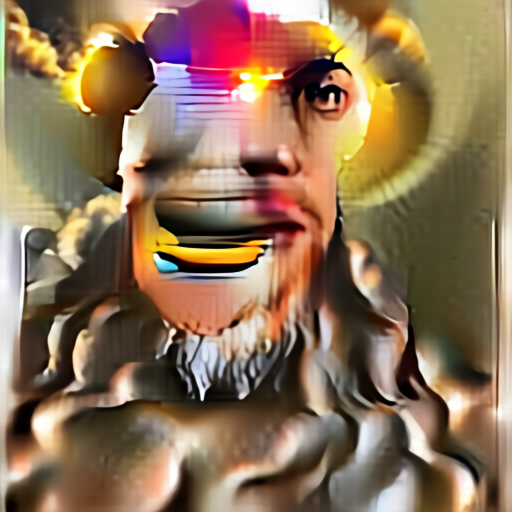




  ##########################################################
   [0, tensor([-3.8945], device='cuda:0', dtype=torch.float16, grad_fn=<MulBackward0>)]  (loss)
 250


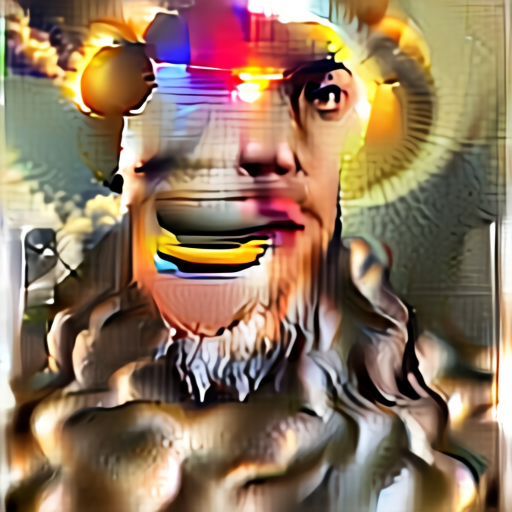

In [ ]:



def checkin(loss):
  global hadies
  print('''
  ##########################################################
  ''',
        loss, ' (loss)\n',itt)
  
  with torch.no_grad():
    
    al = unmap_pixels(torch.sigmoid(model(lats())[:, :3]).cpu().float()).numpy()
    for allls in al:
      displ(allls)
      display.display(display.Image(str(3)+'.png'))
      print('\n')



  # the people spoke and they love "ding"
  output.eval_js('new Audio("https://freesound.org/data/previews/80/80921_1022651-lq.ogg").play()')


def ascend_txt():
  out = unmap_pixels(torch.sigmoid(model(lats())[:, :3].float()))

  

  cutn = 64 # improves quality
  p_s = []
  for ch in range(cutn):
    size = int(sideX*torch.zeros(1,).uniform_(.8, .99))#.normal_(mean=.8, std=.3).clip(.5, .98))
    offsetx = torch.randint(0, sideX - size, ())
    offsety = torch.randint(0, sideX - size, ())
    apper = out[:, :, offsetx:offsetx + size, offsety:offsety + size]
    apper = torch.nn.functional.interpolate(apper, (224,224), mode='bilinear')
    p_s.append(apper)
  into = torch.cat(p_s, 0)
  # into = torch.nn.functional.interpolate(out, (224,224), mode='bilinear')

  into = into + .2 * random.random() * torch.randn_like(into)

  into = nom((into))


  iii = perceptor.encode_image(into)


  lat_l = 0



  return [lat_l, 10*-torch.cosine_similarity(t, iii).view(-1, batch_size).T.mean(1)]

def train(i):
  global hadies
  loss1 = ascend_txt()
  loss = loss1[0] + loss1[1]
  loss = loss.mean()
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  
  # hadies /= 1.01
  # hadies = max(hadies, 1.5)

  for g in optimizer.param_groups:
    g['lr'] = g['lr']*1.005
    
  
  if itt % 50 == 0:
    # print('temp', hadies)
    # print(g['lr'], 'lr')
    checkin(loss1)


itt = 0
for asatreat in range(10000):
  train(itt)
  itt+=1



# Sharpie

In [ ]:
hadies = 130000000
will_it = True

with torch.no_grad():
  lll = lats()
  al = unmap_pixels(torch.sigmoid(model(lll)[:, :3]).cpu().float()).numpy()
  for allls in al:
    displ(allls)
    print('\n')

  # print(lll)
  # print(torch.sum(lll))
  displ(torch.topk(lll.view(batch_size, 8192, 64, 64), k=3, dim=1)[0].cpu().numpy()[0])

In [ ]:
print(lats())